In [1]:
import csv
import re
from brian2 import *
import numpy as np
from scipy.interpolate import interp1d
import brian2.numpy_ as np
import matplotlib.pyplot as plt
import time
import warnings
from random import shuffle
from tqdm.notebook import tqdm


## Visualisation of the operation of the code 'unsupervised_classic_STDP.py'

This code is a draft version of the code 'hyperparameter_architecture/unsupervised_classic_STDP.py'.

The code below implements neuron equations modeling the ML eNeuron using Brian2.
It constructs Spiking Neural Networks (SNNs) with the desired neuron model.
The training, labeling, and evaluation are inspired from Diehl&Cook2015 method 
but applied for solving the XOR problem with eNeuron ML.

This code utilises the architecture : [2,13]+exci+inhi+wta. It means that there is two input neurons fully connected
with 13 outputs neurons with both excitatory and inhibitory synapses conducted with STDP rules. 
Plus, there is a lateral Winner-Take-All synaptic connection between output neurons. It implies 208 synapses.
It utilises ''neuron_eqs_v1''

It displays the evolution of different values, the labelisation and burst maps which can be meaningful

In [2]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()


# Simulation parameters
defaultclock.dt = 0.005*us  

n_train, n_test = 5,5
n_output = 13

v_rest = -80*mV
v_threshold = 60*mV  
v_reset = -100*mV
v0 = -40*mV  
tau = 0.5*ms
tau2 = 15*us
Rm = 5000*Mohm
I0=1*amp
a_v = 1126.6343973469338
b_v = 169200.45773494235
x_threshold_v= 8.3e-11*amp
avoid_error = 0.01*pA
a_value = 6.23667974e13
refrac = 0*us

tau_stdp = 1.88116837
mag_stdp = 0.007070372048
time_sample = 100
time_resting = 20
alpha_decay = 1
alpha_e = 0.15
alpha_i = 0.04
beta_e = 1.9
beta_i = 0.5
avoid_error = 0.01*pA
c = 1

neuron_eqs_v1 = '''
dv/dt =  (v_rest - v) / tau2 + (( int((I + Ie+I_inhi) > x_threshold_v) *((a_v + b_v * log((1-int((I + Ie+I_inhi) > x_threshold_v))+int((I + Ie+I_inhi) > x_threshold_v)*(I+Ie+I_inhi+avoid_error)/(x_threshold_v) ))*I0)/a_value)*Rm) / tau : volt (unless refractory)
Ie =  activity*alpha_e*ge * uS *(80*mV -c*v)*inhi_factor           : amp
I_inhi =  activity*alpha_i*gi * uS *(-120*mV -c*v)           : amp
I : amp
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1
inhi_factor : 1
activity :1
'''


V_a, V_b= 70*mV,90*mV
R_a = Rm*(V_a/mV)/(5/6)/(abs(v_threshold/mV)+abs(v_reset/mV))  #New resistance for rising till V_a
R_b = Rm*(V_b/mV)/(1/6)/(abs(v_threshold/mV)+abs(v_reset/mV)) #New resistance for rising till V_b 
neuron_eqs_v3 = '''
dv/dt =  int((I + Ie+I_inhi) > x_threshold_v) *(v_rest - v) / tau2 + (( int((I + Ie+I_inhi) > x_threshold_v) *((a_v + b_v * log((1-int((I + Ie+I_inhi) > x_threshold_v))+int((I + Ie+I_inhi) > x_threshold_v)*(I+Ie+I_inhi+avoid_error)/(x_threshold_v) ))*I0)/a_value)*Rm) / tau : volt (unless refractory)
Ie =  activity*alpha_e*ge * uS *(80*mV -c*v)*inhi_factor           : amp
I_inhi =  activity*alpha_i*gi * uS *(-120*mV -c*v)           : amp
I : amp
dge/dt = -ge/(beta_e*us)            : 1
dgi/dt = -gi/(beta_i*us)            : 1
inhi_factor : 1
Rm = (R_a)*int(v<(v_reset+V_a)) + (R_b)*int(v>=(v_reset+V_a)) : ohm
activity :1
'''



# Network

In [3]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()

n_input = 2
input_group = NeuronGroup(n_input, neuron_eqs_v1, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
input_group.inhi_factor = 1
input_group.activity = 1


output_group = NeuronGroup(n_output, neuron_eqs_v1, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
output_group.inhi_factor = 1
output_group.activity = 1



#STDP parameters
taupre = tau_stdp*us
taupost = taupre
wmax = 1
dApre = mag_stdp
dApost = -dApre * taupre / taupost * 1.05

stdp_eqs_exci = '''
    w : 1
    alpha : 1 (shared)
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)
'''
pre_eqs_exci='''
    ge_post += w
    Apre += dApre
    w = clip(alpha*w + lr*Apost, 0, wmax)
'''
post_eqs_exci='''
    Apost += dApost
    w = clip(w + lr*Apre, 0, wmax)
'''

stdp_eqs_inhi = '''
    w : 1
    alpha : 1 (shared)
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)
'''
pre_eqs_inhi='''
    gi_post += w
    Apre += dApre
    w = clip(alpha*w + lr*Apost, 0, wmax)
'''
post_eqs_inhi='''
    Apost += dApost
    w = clip(w + lr*Apre, 0, wmax)
'''

synapse_model = "w : 1"


input_sy_exci = Synapses(input_group, output_group, model=stdp_eqs_exci, on_pre=pre_eqs_exci, on_post=post_eqs_exci)
input_sy_exci.connect(True)
input_sy_exci.lr = 0.5
input_sy_exci.w = 'rand() * wmax * 0.8 + 0.1*wmax'
input_sy_exci.delay = 'rand()*0*us'

input_sy_inhi = Synapses(input_group, output_group, model=stdp_eqs_inhi, on_pre=pre_eqs_inhi, on_post=post_eqs_inhi)
input_sy_inhi.connect(True)
input_sy_inhi.lr = 0.5
input_sy_inhi.w = 'rand() * wmax * 0.5 + 0.1*wmax'
input_sy_inhi.delay = 'rand()*0*us'

wta_sy = Synapses(output_group, output_group, model=synapse_model, on_pre='gi_post += w')
wta_sy.connect(condition='i != j')
wta_sy.w = 'rand() * wmax * 1.8 + 0.8*wmax'
input_sy_inhi.delay = 'rand()*0*us'

input_sy_exci.alpha = alpha_decay
input_sy_inhi.alpha = alpha_decay


M_input_exci = StateMonitor(input_sy_exci, ['w'], record=True)
M_input_inhi = StateMonitor(input_sy_inhi, ['w'], record=True)



# Monitors for input neurons
input_spike_monitor = SpikeMonitor(input_group)
input_state_monitor = StateMonitor(input_group, ['v', 'I'], record=True)


# Monitors for output neuron
output_spike_monitor = SpikeMonitor(output_group)
output_state_monitor = StateMonitor(output_group, ['v','Ie','I_inhi'], record=True)



In [4]:
input_group.v = v_rest
input_group.I = [2*nA,0.3*nA] #equivalent to binary input [1,0]
input_group.v = v_rest
output_group.v = v_rest

# Run the simulation
defaultclock.dt = 0.005*us  
duration = time_sample*us
run(duration, report='text', report_period = 60*second)


output_group.activity = [1 for i in range(n_output)]
input_group.I = [0*nA,0*nA]
# Run the simulation
duration = time_resting*us
run(duration, report='text', report_period = 60*second)
input_group.v = v_rest
output_group.v = v_rest


input_group.I = [2*nA,2*nA] # equivalent to binary input [1,1]
input_group.v = v_rest
output_group.v = v_rest

# Run the simulation
duration = time_sample*us
run(duration, report='text', report_period = 60*second)


Starting simulation at t=0. s for a duration of 100. us
100. us (100%) simulated in 6s
Starting simulation at t=100. us for a duration of 20. us
20. us (100%) simulated in 1s
Starting simulation at t=120. us for a duration of 100. us
100. us (100%) simulated in 7s


## Creating XOR Data 


In [5]:
X_train = n_train*[[0,0]] + n_train*[[0,1]] + n_train*[[1,0]] + n_train*[[1,1]]
shuffle(X_train)
y_train = [a ^ b for a, b in X_train]

#print("X_train = ", X_train)
#print("y_train = ", y_train)

X_test = n_test*[[0,0]] + n_test*[[0,1]] + n_test*[[1,0]] + n_test*[[1,1]]
shuffle(X_test)
y_test = [a ^ b for a, b in X_test]

#print("X_test = ", X_test)
#print("y_test = ", y_test)


def from_bit_to_current(x):
    if x == [0,0]:
        return [0.3,0.3]
    elif x == [0,1]:
        return [0.3,2]
    elif x == [1,0]:
        return [2,0.3]
    elif x == [1,1]:
        return [2,2]
    else:
        print(" WARNING PROBLEM !")
        
def from_bit_to_label_2(x):
    if x == [0,0]:
        return 0
    elif x == [0,1]:
        return 1
    elif x == [1,0]:
        return 1
    elif x == [1,1]:
        return 0
    else:
        print(" WARNING PROBLEM !")
        
def from_bit_to_label_4(x):
    if x == [0,0]:
        return 0
    elif x == [0,1]:
        return 1
    elif x == [1,0]:
        return 2
    elif x == [1,1]:
        return 3
    else:
        print(" WARNING PROBLEM !")
        


# Training Part

In [6]:
from brian2 import clear_cache
from brian2 import device
device.reinit()
start_scope()

n_input = 2
input_group = NeuronGroup(n_input, neuron_eqs_v1, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
input_group.inhi_factor = 1
input_group.activity = 1


output_group = NeuronGroup(n_output, neuron_eqs_v1, threshold='v >= v_threshold', reset='v = v_reset', refractory=0*us, method='heun')
output_group.inhi_factor = 1
output_group.activity = 1



input_sy_exci = Synapses(input_group, output_group, model=stdp_eqs_exci, on_pre=pre_eqs_exci, on_post=post_eqs_exci)
input_sy_exci.connect(True)
input_sy_exci.lr = 0.5
input_sy_exci.w = 'rand() * wmax * 0.8 + 0.1*wmax'
input_sy_exci.delay = 'rand()*0*us'

input_sy_inhi = Synapses(input_group, output_group, model=stdp_eqs_inhi, on_pre=pre_eqs_inhi, on_post=post_eqs_inhi)
input_sy_inhi.connect(True)
input_sy_inhi.lr = 0.5
input_sy_inhi.w = 'rand() * wmax * 0.5 + 0.1*wmax'
input_sy_inhi.delay = 'rand()*0*us'

wta_sy = Synapses(output_group, output_group, model=synapse_model, on_pre='gi_post += w')
wta_sy.connect(condition='i != j')
wta_sy.w = 'rand() * wmax * 1.2 + 0.8*wmax'
wta_sy.delay = 'rand()*0*us'

input_sy_exci.alpha = alpha_decay
input_sy_inhi.alpha = alpha_decay



# Monitors for input neurons
input_spike_monitor = SpikeMonitor(input_group)

# Monitors for output neuron
output_spike_monitor = SpikeMonitor(output_group)


print("done")


done


In [7]:

time_per_sample = time_sample * us
resting_time = time_resting * us
input_group.v = v_reset
output_group.v = v_reset

#Create the network
net = Network(input_group, output_group, 
              input_sy_exci, input_sy_inhi,wta_sy,
              input_spike_monitor,output_spike_monitor,
             )

print(output_spike_monitor.count)

<spikemonitor.count: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>


  0%|          | 0/20 [00:00<?, ?it/s]

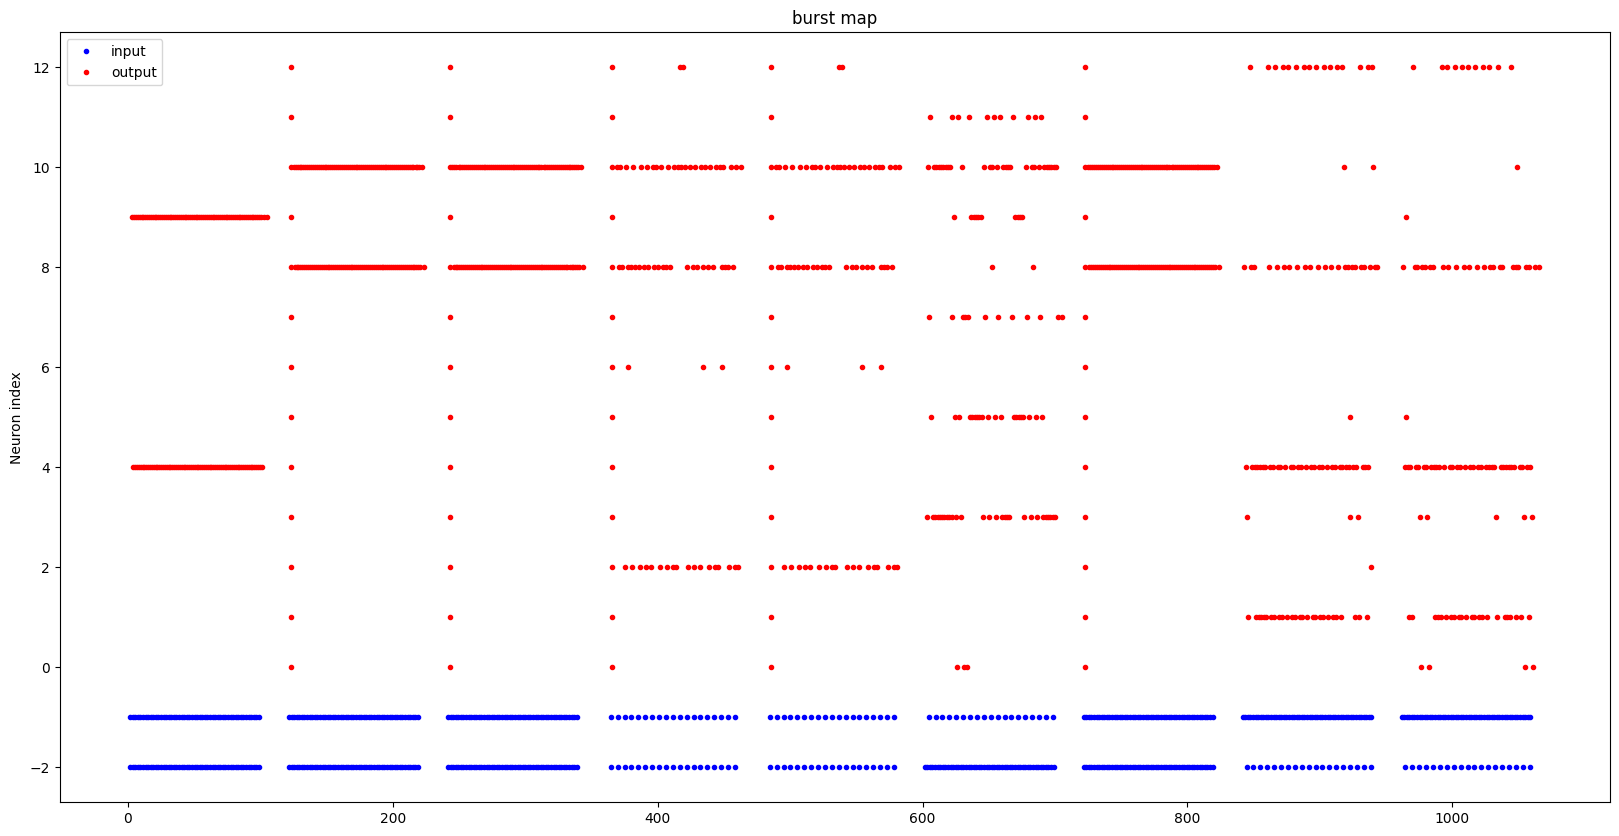

It has taken  143.9286286830902 s to run for the epoch 


In [8]:

weight_evol_exci = []
weight_evol_inhi = []

frequency_evolution_n0 = [[],[],[],[]]
frequency_evolution_n1 = [[],[],[],[]]
frequency_evolution_n2 = [[],[],[],[]]
frequency_evolution_n3 = [[],[],[],[]]

spikes2 = np.zeros((2, n_output))
spikes4 = np.zeros((4, n_output))

old_spike_counts = np.zeros(n_output)
old_spike_counts = np.copy(output_spike_monitor.count)


tic = time.time()
for j, (sample, label) in enumerate(tqdm(zip(X_train, y_train), total=len(X_train))):


    input_group.v = v_rest
    output_group.v = v_rest
    input_group.I = from_bit_to_current(sample) * nA
    # Start the training simulation
    net.run(time_per_sample)
    
    counter_spike = output_spike_monitor.count - old_spike_counts
    spikes2[from_bit_to_label_2(sample)] += counter_spike 
    spikes4[from_bit_to_label_4(sample)] += counter_spike 
    
    
    frequency_evolution_n0[from_bit_to_label_4(sample)].append(counter_spike[0]/time_per_sample)
    frequency_evolution_n1[from_bit_to_label_4(sample)].append(counter_spike[1]/time_per_sample)
    frequency_evolution_n2[from_bit_to_label_4(sample)].append(counter_spike[2]/time_per_sample)
    frequency_evolution_n3[from_bit_to_label_4(sample)].append(counter_spike[3]/time_per_sample)
    


    # Allow the variables to return to their resting values
    input_group.I = 0 * nA
    net.run(resting_time)
    input_group.v = v_rest
    output_group.v = v_rest
    old_spike_counts = np.copy(output_spike_monitor.count)

    if j >= 8 and j<9:
        plt.figure(figsize=(20, 10)) 
        plot(input_spike_monitor.t/us, input_spike_monitor.i+np.array([-n_input for i in range(len(input_spike_monitor.i))]), '.b',label='input')
        plot(output_spike_monitor.t/us, output_spike_monitor.i, '.r',label='output')
        plt.ylabel('Neuron index')
        plt.title("burst map")
        plt.legend()
        plt.show()
        
        
    #NORMALISATION :
    weight_matrix = np.zeros([n_input, n_output])
    weight_matrix[input_sy_exci.i, input_sy_exci.j] = input_sy_exci.w
    sumCol = np.sum(weight_matrix, axis=0)
    colFactors = 1/sumCol
    for jj in range(n_output):
        weight_matrix[:,jj] *= colFactors[jj]
    input_sy_exci.w = weight_matrix[input_sy_exci.i, input_sy_exci.j]

    weight_matrix = np.zeros([n_input, n_output])
    weight_matrix[input_sy_inhi.i, input_sy_inhi.j] = input_sy_inhi.w
    sumCol = np.sum(weight_matrix, axis=0)
    colFactors = 0.5/sumCol
    for jj in range(n_output):
        weight_matrix[:,jj] *= colFactors[jj]
    input_sy_inhi.w = weight_matrix[input_sy_inhi.i, input_sy_inhi.j]
    
    
    ## Observation weight evolution
    weight = [input_sy_exci.w[i] for i in range(len(input_sy_exci.w))]
    weight_evol_exci.append(weight)
    weight = [input_sy_inhi.w[i] for i in range(len(input_sy_inhi.w))]
    weight_evol_inhi.append(weight)



tac = time.time()
print("It has taken ", tac-tic,"s to run for the epoch ")
            

## Observing the spiking range of each neuron

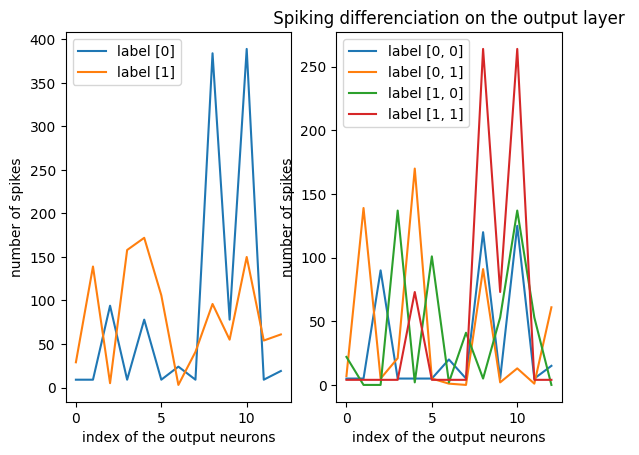

In [9]:


plt.subplot(1, 2, 1)  
label_list = [[0],[1]]
for i in range(len(spikes2)):
    if spikes2[i].any() != np.zeros(len(spikes2[i])).any():
        plt.plot(range(len(spikes2[i])),spikes2[i], label=f'label {label_list[i]}')
plt.ylabel('number of spikes')
plt.xlabel('index of the output neurons')
plt.legend()

plt.subplot(1, 2, 2)  
label_list = [[0,0],[0,1],[1,0],[1,1]]
for i in range(len(spikes4)):
    if spikes4[i].any() != np.zeros(len(spikes4[i])).any():
        plt.plot(range(len(spikes4[i])),spikes4[i], label=f'label {label_list[i]}')

plt.ylabel('number of spikes')
plt.xlabel('index of the output neurons')
plt.title(" Spiking differenciation on the output layer ")
plt.legend()
plt.show()

## Observing the evoluton of the spiking rate with epoch

for neuron 3, label : [0, 0]  last frequency =  10. kHz
for neuron 3, label : [0, 1]  last frequency =  60. kHz
for neuron 3, label : [1, 0]  last frequency =  0.32 MHz
for neuron 3, label : [1, 1]  last frequency =  10. kHz


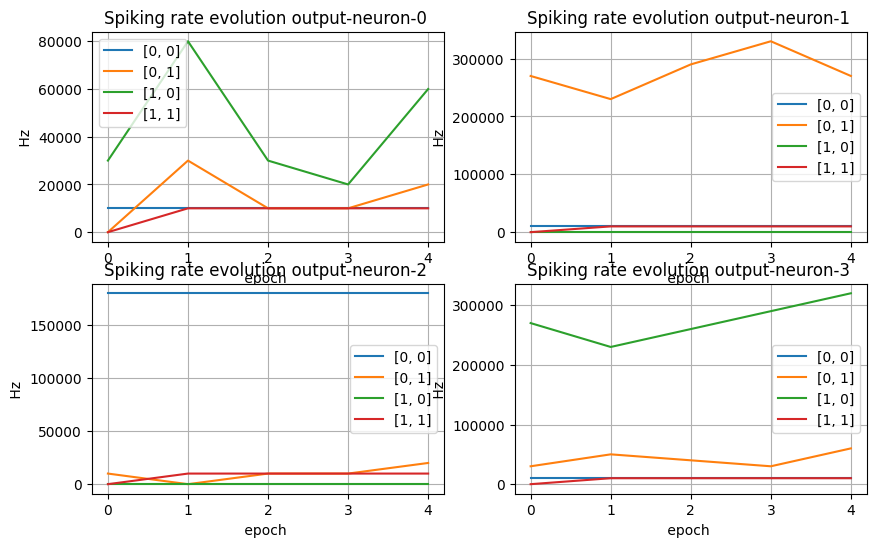

In [10]:

plt.figure(figsize=(10, 6)) 

label_list = [[0,0],[0,1],[1,0],[1,1]]
plt.subplot(2, 2, 1)  
for i,label in enumerate(label_list):
    plt.plot(range(len(frequency_evolution_n0[i])), frequency_evolution_n0[i], label=f'{label}') 
plt.title('Spiking rate evolution output-neuron-0 ')
plt.xlabel(f' epoch  ')
plt.ylabel(' Hz ')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)  
for i,label in enumerate(label_list):
    plt.plot(range(len(frequency_evolution_n1[i])), frequency_evolution_n1[i], label=f'{label}')  
plt.title('Spiking rate evolution output-neuron-1 ')
plt.xlabel(f' epoch  ')
plt.ylabel(' Hz ')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)  
for i,label in enumerate(label_list):
    plt.plot(range(len(frequency_evolution_n2[i])), frequency_evolution_n2[i], label=f'{label}')  
plt.title('Spiking rate evolution output-neuron-2 ')
plt.xlabel(f' epoch  ')
plt.ylabel(' Hz ')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)  
for i,label in enumerate(label_list):
    plt.plot(range(len(frequency_evolution_n3[i])), frequency_evolution_n3[i], label=f'{label}')  
    print("for neuron 3, label :",label, " last frequency = ",frequency_evolution_n3[i][-1])

plt.title('Spiking rate evolution output-neuron-3 ')
plt.xlabel(f' epoch  ')
plt.ylabel(' Hz ')
plt.grid(True)
plt.legend()

plt.show()


## Weight visualisation

 len(weight_evol_input) =  20
 len(weight_evol_input[0]) =  26


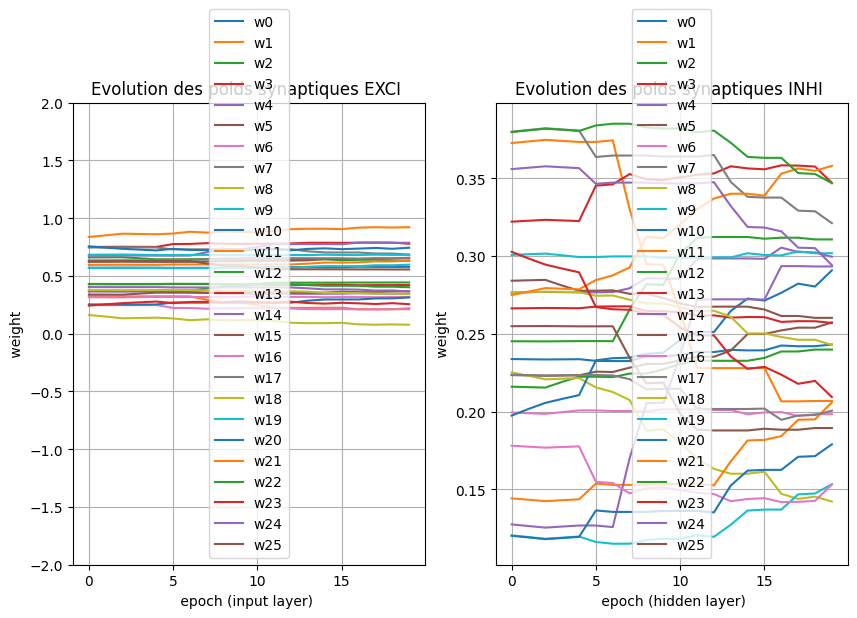

In [11]:
print(" len(weight_evol_input) = ", len(weight_evol_exci))
print(" len(weight_evol_input[0]) = ", len(weight_evol_exci[0]))


plt.figure(figsize=(10, 6)) 

plt.subplot(1, 2, 1)  
for idx_w in range(len(weight_evol_exci[0])):
    weight = [ligne[idx_w] for ligne in weight_evol_exci]
    plt.plot(range(len(weight)), weight, label=f'w{idx_w}')  

plt.title('Evolution des poids synaptiques EXCI ')
plt.xlabel(f' epoch (input layer)  ')
plt.ylabel(' weight ')
plt.ylim(-wmax-1, wmax+1) 
plt.grid(True)
plt.legend()


plt.subplot(1, 2, 2)  
for idx_w in range(len(weight_evol_inhi[0])):
    weight = [ligne[idx_w] for ligne in weight_evol_inhi]
    plt.plot(range(len(weight)), weight, label=f'w{idx_w}')  

plt.title('Evolution des poids synaptiques INHI ')
plt.xlabel(f' epoch (hidden layer)')
plt.ylabel(' weight ')
plt.grid(True)
plt.legend()



plt.show()


# Labelisation

  0%|          | 0/10 [00:00<?, ?it/s]

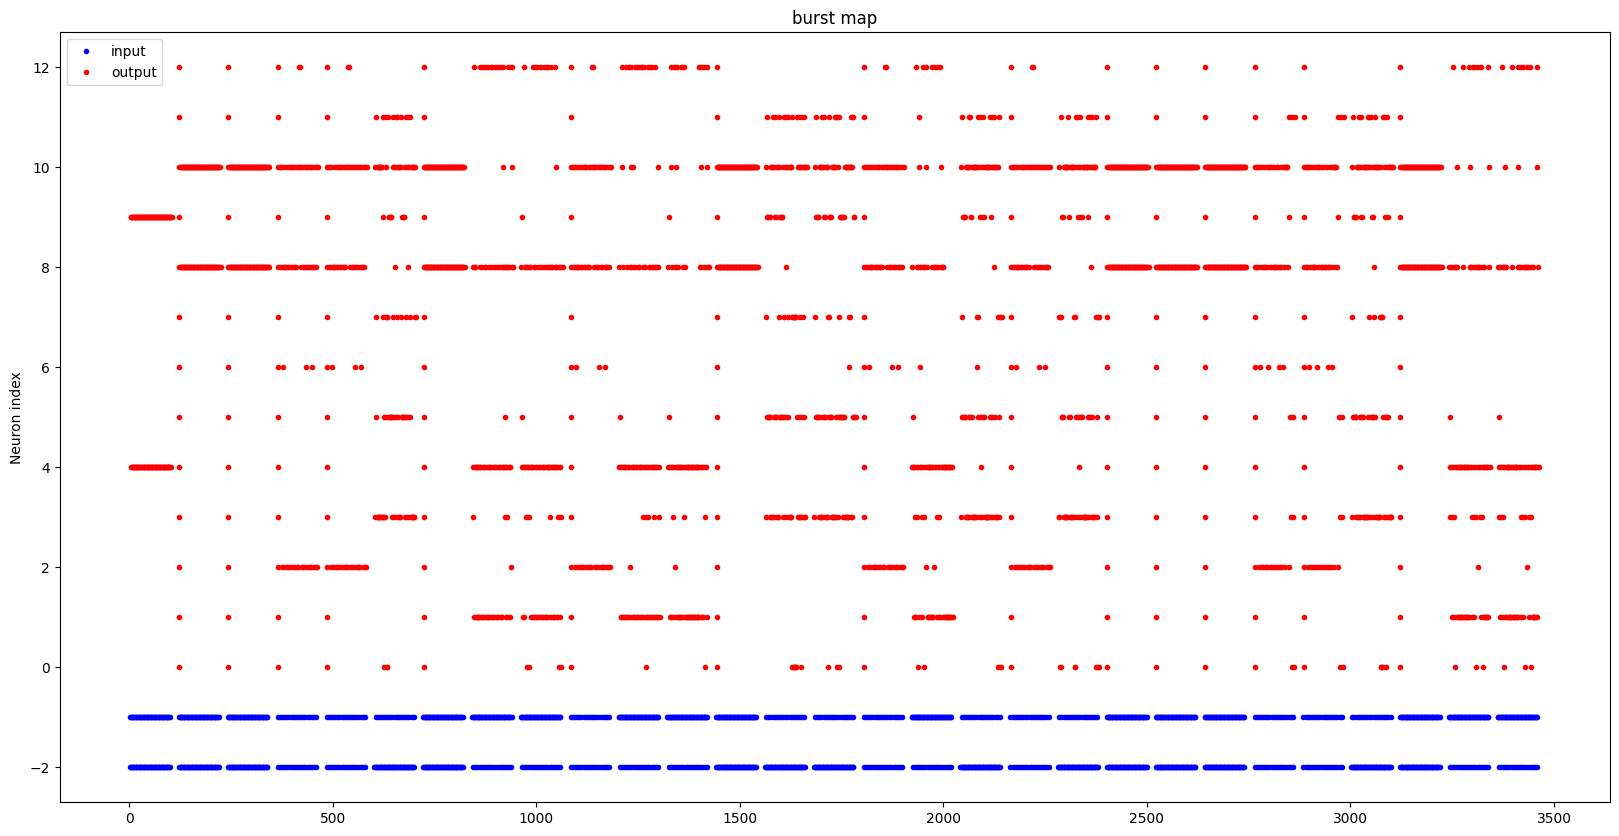

It has taken  49.656447887420654 s to run for the epoch 


In [12]:
# Desactivate STDP plasticity
input_sy_exci.lr = 0
input_sy_inhi.lr = 0

input_group.v = v_reset
output_group.v = v_reset


weight_evol_exci = []
weight_evol_inhi = []


spikes2 = np.zeros((2, n_output))
spike4 = np.zeros((4, n_output))

old_spike_counts = np.zeros(n_output)
old_spike_counts = np.copy(output_spike_monitor.count)


label_percent = 0.5 #50% of the previous trained data will be re-used to label output neurons
nb_label = int(label_percent*len(y_train))
X_labeling = X_train[:nb_label]
y_labeling = y_train[:nb_label]


tic = time.time()
for j, (sample, label) in enumerate(tqdm(zip(X_labeling, y_labeling), total=len(X_labeling))):
    
    input_group.I = from_bit_to_current(sample) * nA
    #  Start the simulation
    input_group.v = v_rest
    output_group.v = v_rest
    net.run(time_per_sample)
    
    counter_spike = output_spike_monitor.count - old_spike_counts
    spikes2[from_bit_to_label_2(sample)] += counter_spike    
    spikes4[from_bit_to_label_4(sample)] += counter_spike    
    


    # Allow the variables to return to their resting values
    input_group.I = 0 * nA
    net.run(resting_time) 
    input_group.v = v_rest
    output_group.v = v_rest
    old_spike_counts = np.copy(output_spike_monitor.count)

    if j >= 8 and j<9:
        plt.figure(figsize=(20, 10)) 
        plot(input_spike_monitor.t/us, input_spike_monitor.i+np.array([-n_input for i in range(len(input_spike_monitor.i))]), '.b',label='input')
        plot(output_spike_monitor.t/us, output_spike_monitor.i, '.r',label='output')
        plt.ylabel('Neuron index')
        plt.title("burst map")
        plt.legend()
        plt.show()
    
    
    # Observation weight evolution
    weight = [input_sy_exci.w[i] for i in range(len(input_sy_exci.w))]
    weight_evol_exci.append(weight)
    weight = [input_sy_inhi.w[i] for i in range(len(input_sy_inhi.w))]
    weight_evol_inhi.append(weight)



tac = time.time()
print("It has taken ", tac-tic,"s to run for the epoch ")
    
    


## Observing the spiking range of each neuron

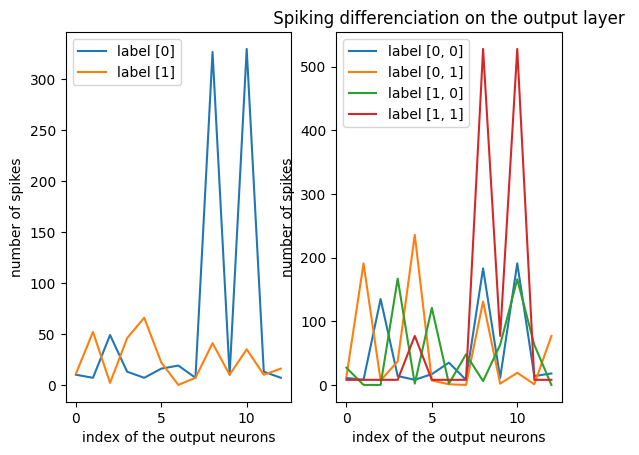

In [13]:

plt.subplot(1, 2, 1)  
label_list = [[0],[1]]
for i in range(len(spikes2)):
    if spikes2[i].any() != np.zeros(len(spikes2[i])).any():
        plt.plot(range(len(spikes2[i])),spikes2[i], label=f'label {label_list[i]}')
plt.ylabel('number of spikes')
plt.xlabel('index of the output neurons')
plt.legend()

plt.subplot(1, 2, 2)  
label_list = [[0,0],[0,1],[1,0],[1,1]]
for i in range(len(spikes4)):
    if spikes4[i].any() != np.zeros(len(spikes4[i])).any():
        plt.plot(range(len(spikes4[i])),spikes4[i], label=f'label {label_list[i]}')
plt.ylabel('number of spikes')
plt.xlabel('index of the output neurons')
plt.title(" Spiking differenciation on the output layer ")
plt.legend()
plt.show()



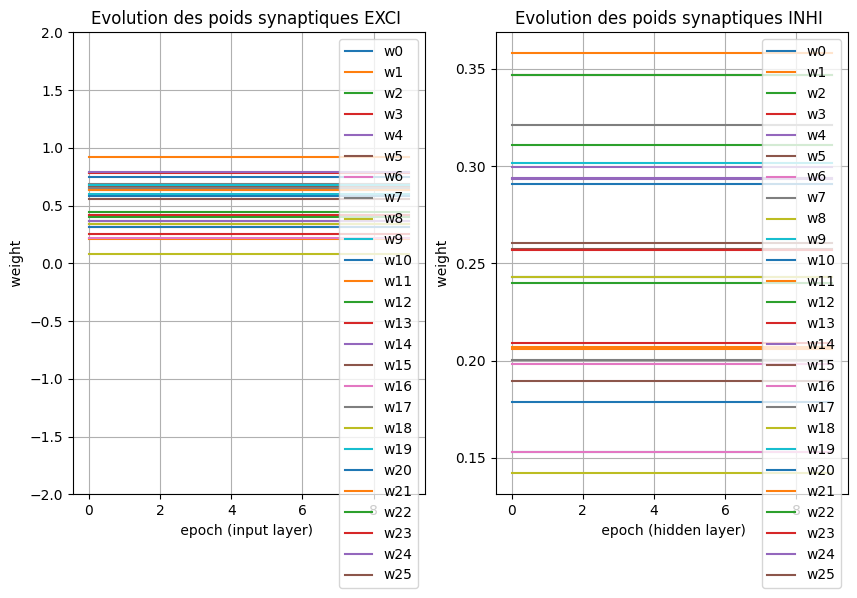

In [14]:
#Weight evolution


plt.figure(figsize=(10, 6)) 

plt.subplot(1, 2, 1)  
for idx_w in range(len(weight_evol_exci[0])):
    weight = [ligne[idx_w] for ligne in weight_evol_exci]
    plt.plot(range(len(weight)), weight, label=f'w{idx_w}')  

plt.title('Evolution des poids synaptiques EXCI ')
plt.xlabel(f' epoch (input layer)  ')
plt.ylabel(' weight ')
plt.ylim(-wmax-1, wmax+1) 
plt.grid(True)
plt.legend()


plt.subplot(1, 2, 2)  
for idx_w in range(len(weight_evol_inhi[0])):
    weight = [ligne[idx_w] for ligne in weight_evol_inhi]
    plt.plot(range(len(weight)), weight, label=f'w{idx_w}')  

plt.title('Evolution des poids synaptiques INHI ')
plt.xlabel(f' epoch (hidden layer)')
plt.ylabel(' weight ')
plt.grid(True)
plt.legend()



plt.show()


## Result of the labelisation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 labeled_neurons4 =  [2 1 0 2 1 2 0 2 3 3 3 2 1]
 redundancy_neurons4 =  [2 3 5 3 0]


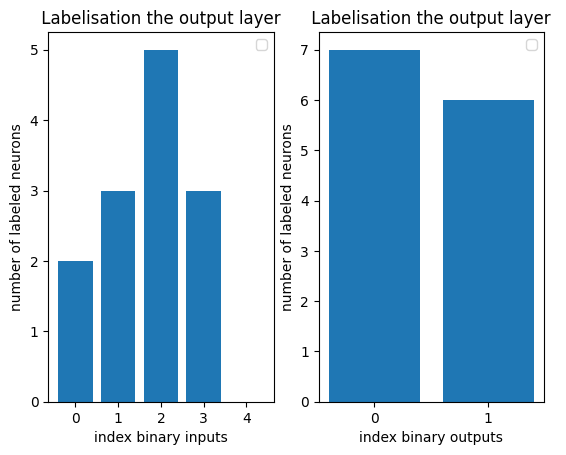

 labeled_neurons2 =  [1 1 0 1 1 1 0 0 0 0 0 0 1]
 redundancy_neurons2 =  [7 6]


In [15]:


plt.subplot(1, 2, 1)  
labeled_neurons = np.argmax(spikes4, axis=0)

redundancy_neuron = np.bincount(labeled_neurons, minlength=5)
bar(range(len(redundancy_neuron)),redundancy_neuron)
xticks(range(len(redundancy_neuron)))
plt.xlabel('index binary inputs')
plt.ylabel('number of labeled neurons')
plt.title(" Labelisation the output layer ")
plt.legend()

print(" labeled_neurons4 = ", labeled_neurons)
print(" redundancy_neurons4 = ", redundancy_neuron)

plt.subplot(1, 2, 2)  
labeled_neurons = np.argmax(spikes2, axis=0)

redundancy_neuron = np.bincount(labeled_neurons, minlength=2)
bar(range(len(redundancy_neuron)),redundancy_neuron)
xticks(range(len(redundancy_neuron)))
plt.xlabel('index binary outputs')
plt.ylabel('number of labeled neurons')
plt.title(" Labelisation the output layer ")
plt.legend()
plt.show()

print(" labeled_neurons2 = ", labeled_neurons)
print(" redundancy_neurons2 = ", redundancy_neuron)

# Evaluation

  0%|          | 0/20 [00:00<?, ?it/s]

output_label_max =  1 output_label_mean =  1 output_label_temporal =  0  and int(label) =  1
output_label_max =  0 output_label_mean =  0 output_label_temporal =  0  and int(label) =  0
output_label_max =  1 output_label_mean =  1 output_label_temporal =  0  and int(label) =  1
output_label_max =  1 output_label_mean =  1 output_label_temporal =  0  and int(label) =  1
output_label_max =  0 output_label_mean =  0 output_label_temporal =  0  and int(label) =  0
output_label_max =  1 output_label_mean =  0 output_label_temporal =  0  and int(label) =  1
output_label_max =  1 output_label_mean =  1 output_label_temporal =  0  and int(label) =  1
output_label_max =  0 output_label_mean =  0 output_label_temporal =  0  and int(label) =  0
output_label_max =  0 output_label_mean =  0 output_label_temporal =  0  and int(label) =  0


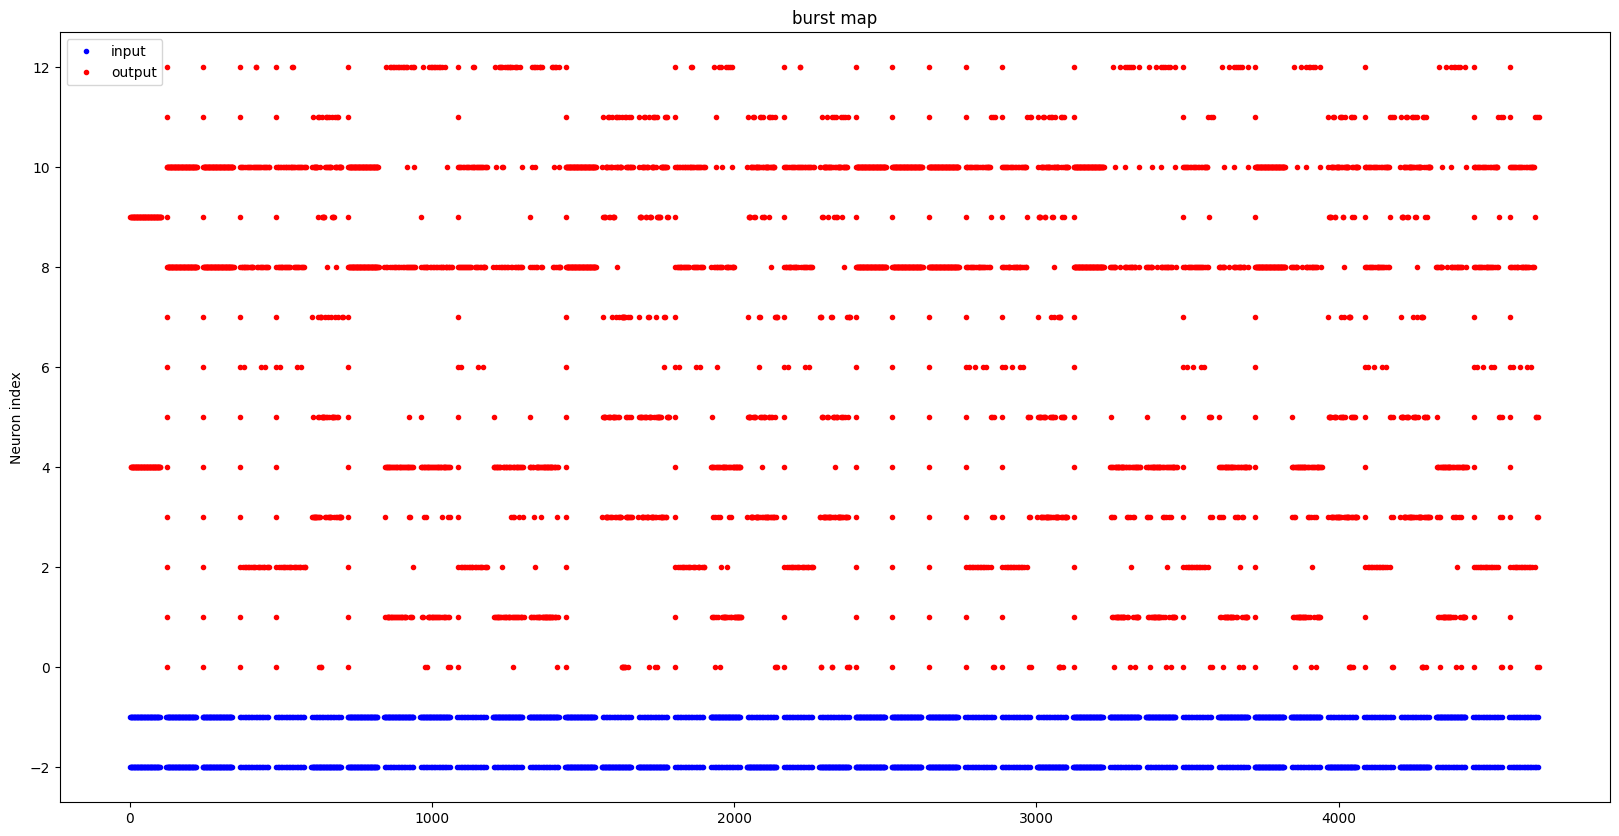

output_label_max =  0 output_label_mean =  0 output_label_temporal =  0  and int(label) =  0
output_label_max =  1 output_label_mean =  0 output_label_temporal =  0  and int(label) =  1
output_label_max =  0 output_label_mean =  0 output_label_temporal =  0  and int(label) =  0
output_label_max =  1 output_label_mean =  0 output_label_temporal =  0  and int(label) =  1
output_label_max =  0 output_label_mean =  0 output_label_temporal =  0  and int(label) =  0
output_label_max =  0 output_label_mean =  0 output_label_temporal =  0  and int(label) =  0
It has taken  65.1166558265686 s for the evaluation 
The model accuracy with num_correct_output_max is : 1.000
The model accuracy with num_correct_output_mean is : 0.700
The model accuracy with num_correct_output_temporal is : 0.500


In [16]:
input_sy_exci.lr = 0
input_sy_inhi.lr = 0

input_group.v = v_reset
output_group.v = v_reset


weight_evol_exci = []
weight_evol_inhi = []


spikes2 = np.zeros((2, n_output))
spikes4 = np.zeros((4, n_output))

old_spike_counts = np.zeros(n_output)
old_spike_counts = np.copy(output_spike_monitor.count)


frequency_evolution_n0 = [[],[],[],[]]
frequency_evolution_n1 = [[],[],[],[]]
frequency_evolution_n2 = [[],[],[],[]]
frequency_evolution_n3 = [[],[],[],[]]

num_correct_output_max = 0
num_correct_output_mean = 0
num_correct_output_temporal = 0

classifi_matrix = np.zeros((2,1))

tic = time.time()
for j, (sample, label) in enumerate(tqdm(zip(X_test, y_test), total=len(y_test))):


    input_group.I = from_bit_to_current(sample) * nA
    input_group.v = v_rest
    output_group.v = v_rest
    # Start the simulation
    net.run(time_per_sample)
    
    counter_spike = output_spike_monitor.count - old_spike_counts
    #print(" counter_spike = ", counter_spike)
    spikes2[from_bit_to_label_2(sample)] += counter_spike
    spikes4[from_bit_to_label_4(sample)] += counter_spike
    
    for k in range(len(counter_spike)):
        classifi_matrix[labeled_neurons[k],0] += counter_spike[k]/redundancy_neuron[labeled_neurons[k]] #normalisation to equilibrate each labelled population
            
    # Prediction of the SNN post labelisation
    output_label_max = labeled_neurons[np.argmax(counter_spike)]
    output_label_mean = np.argmax(classifi_matrix)
    output_label_temporal = labeled_neurons[output_spike_monitor.i[0]]
        
    # Check prediction of the class of the sample
    if j < 15:
        print("output_label_max = ", output_label_max,"output_label_mean = ",output_label_mean,"output_label_temporal = ",output_label_temporal, " and int(label) = ", int(label))
    if output_label_max == int(label):
        num_correct_output_max += 1
    if output_label_mean == int(label):
        num_correct_output_mean += 1
    if output_label_temporal == int(label):
        num_correct_output_temporal += 1
    
    
    frequency_evolution_n0[from_bit_to_label_4(sample)].append(counter_spike[0]/time_per_sample)
    frequency_evolution_n1[from_bit_to_label_4(sample)].append(counter_spike[1]/time_per_sample)
    frequency_evolution_n2[from_bit_to_label_4(sample)].append(counter_spike[2]/time_per_sample)
    frequency_evolution_n3[from_bit_to_label_4(sample)].append(counter_spike[3]/time_per_sample)
    

    # Allow the variables to return to their resting values
    input_group.I = 0 * nA
    net.run(resting_time) 
    input_group.v = v_reset
    output_group.v = v_reset
    old_spike_counts = np.copy(output_spike_monitor.count)
    
    if j >= 8 and j<9:
        plt.figure(figsize=(20, 10)) 
        plot(input_spike_monitor.t/us, input_spike_monitor.i+np.array([-n_input for i in range(len(input_spike_monitor.i))]), '.b',label='input')
        plot(output_spike_monitor.t/us, output_spike_monitor.i, '.r',label='output')
        plt.ylabel('Neuron index')
        plt.title("burst map")
        plt.legend()
        plt.show()



tac = time.time()
print("It has taken ", tac-tic,"s for the evaluation ")

print("The model accuracy with num_correct_output_max is : %.3f" % (num_correct_output_max / len(X_test)))
print("The model accuracy with num_correct_output_mean is : %.3f" % (num_correct_output_mean / len(X_test)))
print("The model accuracy with num_correct_output_temporal is : %.3f" % (num_correct_output_temporal / len(X_test)))



## Observing the spiking range of each neuron

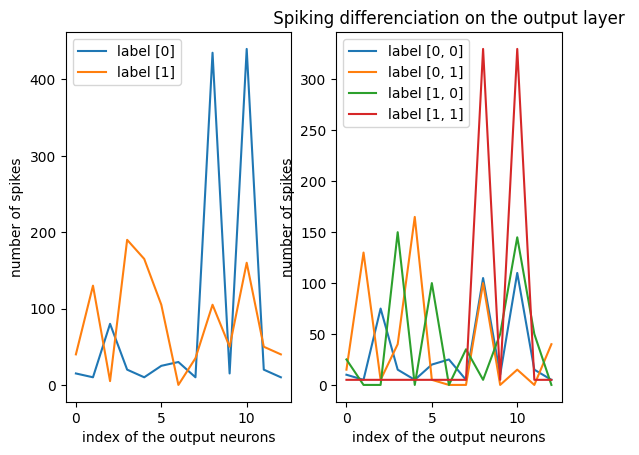

In [17]:


plt.subplot(1, 2, 1)  
label_list = [[0],[1]]
for i in range(len(spikes2)):
    if spikes2[i].any() != np.zeros(len(spikes2[i])).any():
        plt.plot(range(len(spikes2[i])),spikes2[i], label=f'label {label_list[i]}')
plt.ylabel('number of spikes')
plt.xlabel('index of the output neurons')
plt.legend()

plt.subplot(1, 2, 2)  
label_list = [[0,0],[0,1],[1,0],[1,1]]
for i in range(len(spikes4)):
    if spikes4[i].any() != np.zeros(len(spikes4[i])).any():
        plt.plot(range(len(spikes4[i])),spikes4[i], label=f'label {label_list[i]}')
plt.ylabel('number of spikes')
plt.xlabel('index of the output neurons')
plt.title(" Spiking differenciation on the output layer ")
plt.legend()
plt.show()

## Observing the spiking rate evolution post training
It's just a quick check to be sure that it's indeed constant

for neuron 0, label : [0, 0]  last frequency =  150. kHz
for neuron 0, label : [0, 1]  last frequency =  10. kHz
for neuron 0, label : [1, 0]  last frequency =  0. Hz
for neuron 0, label : [1, 1]  last frequency =  10. kHz
for neuron 1, label : [0, 0]  last frequency =  30. kHz
for neuron 1, label : [0, 1]  last frequency =  80. kHz
for neuron 1, label : [1, 0]  last frequency =  300. kHz
for neuron 1, label : [1, 1]  last frequency =  10. kHz


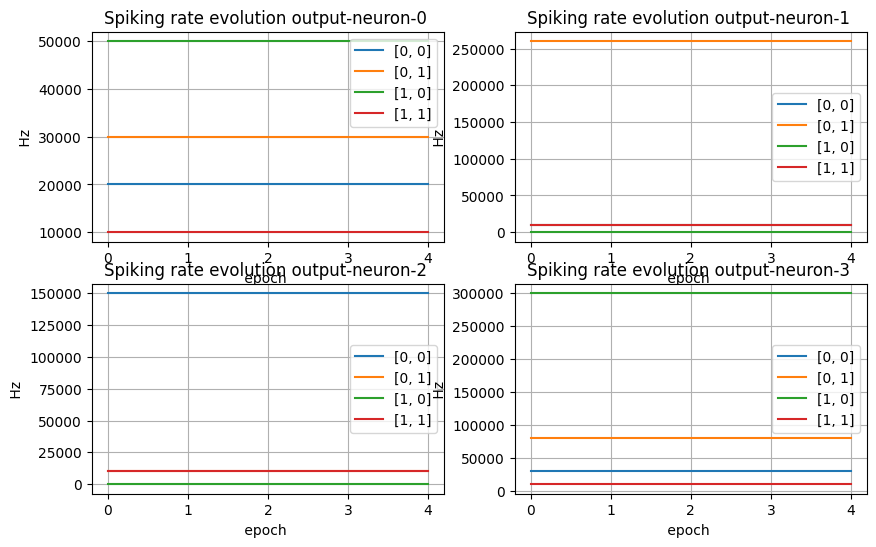

In [18]:

plt.figure(figsize=(10, 6)) 

label_list = [[0,0],[0,1],[1,0],[1,1]]
plt.subplot(2, 2, 1)  
for i,label in enumerate(label_list):
    plt.plot(range(len(frequency_evolution_n0[i])), frequency_evolution_n0[i], label=f'{label}')  

plt.title('Spiking rate evolution output-neuron-0 ')
plt.xlabel(f' epoch  ')
plt.ylabel(' Hz ')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)  
for i,label in enumerate(label_list):
    plt.plot(range(len(frequency_evolution_n1[i])), frequency_evolution_n1[i], label=f'{label}')  

plt.title('Spiking rate evolution output-neuron-1 ')
plt.xlabel(f' epoch  ')
plt.ylabel(' Hz ')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)  
for i,label in enumerate(label_list):
    plt.plot(range(len(frequency_evolution_n2[i])), frequency_evolution_n2[i], label=f'{label}') 
    print("for neuron 0, label :",label, " last frequency = ",frequency_evolution_n2[i][-1])

plt.title('Spiking rate evolution output-neuron-2 ')
plt.xlabel(f' epoch  ')
plt.ylabel(' Hz ')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)  
for i,label in enumerate(label_list):
    plt.plot(range(len(frequency_evolution_n3[i])), frequency_evolution_n3[i], label=f'{label}')  
    print("for neuron 1, label :",label, " last frequency = ",frequency_evolution_n3[i][-1])

plt.title('Spiking rate evolution output-neuron-3 ')
plt.xlabel(f' epoch  ')
plt.ylabel(' Hz ')
plt.grid(True)
plt.legend()

plt.show()
